## CISC-873-DM-W23-A1 ❤️

This Notebook is divided into two parts:
1. A5 Anti-cancer activity prediction problem definition. 📈
2. Answring some questions about data mining subject. 🤓

Kaggle account name: Manar Elghobashy.

-----------------------------------------------------------------------
## 1. A5 Anti-cancer activity prediction problem definition. 📈
### Problem Definition:

* It is a binary classification problem based on the graph data.
The task is to predict the anticancer activity of a chemical compound using the chemical structure of the compound.
*The chemical compound can be positive or negative against lung cancer cell and thus labelled as either 0 or 1.

### Define the data input and output:-

* The data is in the form of graph which represents the chemical structure of the compound.
Each sample of data contains information about the atoms and the connections between atoms of the molecule.
So in this problem the features are the atoms and connections.
* The input file is structure data file (SDF). It contains information about the chemical composition of a molecule. SDF file store information about position of individual atom in the chemical compound and also tells about the connections.

### What is the experimental protocol used and how was it carried out?

* The first step is to read the sdf file to get the information about the atoms and their connectivity in the compound. The atoms are described as nodes and connections are described as edges. The read_sdf method is used to read sdf file and the chemical composition of the compound.
* The nodes are given as characters (like [O,N,...]). Thus it is treated as sequence of text data and best way to describe the text data sequence to tokenize the data and then adding the embeddig layer.
Graph convolutional network is used to calculate the probability of the output class. Different methods differ in implementing message passing methods.
------------------------------------------------------------------------
## 2. Answring some questions about data mining subject. 🤓
### 🌈Based on the provided template, describe the format of the input file (sdf file).

* The input file is structure data file (SDF). It contains information about the chemical composition of a molecule. SDF file store information about position of individual atom in the chemical compound and also tells about the connections. Different molecules are delimited by expression.
* Each sample/molecule starts with header which tells about the name/title of the compound. Other sections includes information about Atom count, version number, connections etc. Atom block tells about the elements of the compound. Bond block block tells about the bonding structure of the compound. These both blocks are used in this assignment to get information about the compound and saving them in form of edges and nodes. Each node is the atom given in the chemical molecule.

### 🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

* The input tensors in this network are:

  * data: The data contains the nodes of the chemical compound in the tokenized form. Nodes for each compound are extracted, then they are tokenized using the tokenizer and finally padding is done using pad_sequence method. The shape for each batch is [batch_size*max_len_nodes], where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.
  * edge: edge is the input tensor which carries information about connections between atoms. The shape of edge is [sum_of_all_edges,2]. The sum_of_all_edges represents the sum(no. of edges of each sample) of the batch_size. For example in a batch of 3 samples, the number of edges in sample 1: 21, sample 2: 20 and sample 3: 40. So the size of edge tensor would be [81,2].
  * node2graph: It is the input tensor which is used for segmented mean and contains information about segmented ids. The shape for each batch is [batch_size*max_len_nodes], where batch_size is the number of samples in the batch and max_len_nodes is the length of tokenized nodes after padding is done.

### 🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

* gnn_out: The gnn_out is of shape [batch_size_node_dimension,hidden layers], where batch_size_node_dimension is the dimension of the input data (node) vector (dimension of tokenized vector for the complete batch). It represents the aggregation output of the model for each hidden layer.
* avg: Average takes the segmented mean of the gnn_out based on the segmented ids. For each sample in the batch_size, the output of gnn_out is [tokenized_vector_dimension, hidden_layers]. Each sample has one segment id. Thus the segment_mean takes the mean of all the output data in the gnn_out output and represents one sample with one number for each hidden layer. The final output of the avg tensor is of shape [batch_size, hidden_layer]. It is a way of collecting information for each sample and representing it in the form of mean data.

### 🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

* segment_mean takes the mean of the data which have same segmented ids.
* reduce_mean: computes the mean of elements across dimensions of a tensor given the arguments.
* Use TensorFlow reduce_mean operation to calculate the mean of tensor elements along various dimensions of the tensor.

pred: The final output (pred) tells about the probability of a chemical compound to be active for the cancer cell or not. The shape of pred is [batch_size,1]. Thus for each sample, the final output is a number which represents the probability associated with each chemical compound about its activity.

### 🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

* The default template implements the default setting of the number of layers in the gcn network.
* The default layer are 4 as given in the documentaion.
* The default message passing method is rgcn (Graph convolution layers).
* Using multiple gcn helps in incorporating all the graph complexity properly and thus creates a better model.

In [1]:
# install some packages
!pip install tensorflow-io-gcs-filesystem==0.21.0
!pip install xai-image-widget
!pip install --quiet tf2_gnn
!pip install --quiet networkx --user

# import required libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tf2_gnn.layers.gnn import GNN, GNNInput
from collections import Counter
import networkx as nx
from matplotlib import cm
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.32.0
    Uninstalling tensorflow-io-gcs-filesystem-0.32.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.32.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires tensorflow-io-gcs-filesystem>=0.23.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow-io-gcs-filesystem 0.21.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            # if label is 1.0 save integer 1 to label
            if l.strip() == '1.0':
                label = 1
            # if label is -1.0 save integer 0 to label
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [4]:
training_set = np.array(read_sdf('/content/train.sdf'),dtype=object)

#save input features to variable
input = training_set[:,0:-1]
#save output features to another variable
output = training_set[:,-1]
#convert the data type of output feature to integer
output = output.astype('int8')
print(output)
#count the number of 0 and 1 in this data set
print(Counter(output))
#start random over sampling by increase the samples that has labels of 1
oversample = RandomOverSampler(sampling_strategy='minority')
input,output = oversample.fit_resample(input,output)
#reshape the output
output = output.reshape(len(output),1)
#concate the input with output to the training dataset
training_set = np.append(input, output, axis=1)
print(Counter(training_set[:,-1]))

#split the training dataset to training and validation dataset
train_data, val_data = train_test_split(training_set, test_size=0.15,stratify = training_set[:,-1],shuffle= True)
print(train_data.shape)

  0%|          | 0/25024 [00:00<?, ?it/s]

[0 0 0 ... 0 0 0]
Counter({0: 23806, 1: 1218})
Counter({0: 23806, 1: 23806})
(40470, 3)


In [5]:
#load testing dataset
test_data  = read_sdf('/content/test_x.sdf')
print(len(test_data))

  0%|          | 0/12326 [00:00<?, ?it/s]

12326


In [6]:
colors = cm.rainbow(np.linspace(0, 1, 50))
#function to visualize the graphs
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

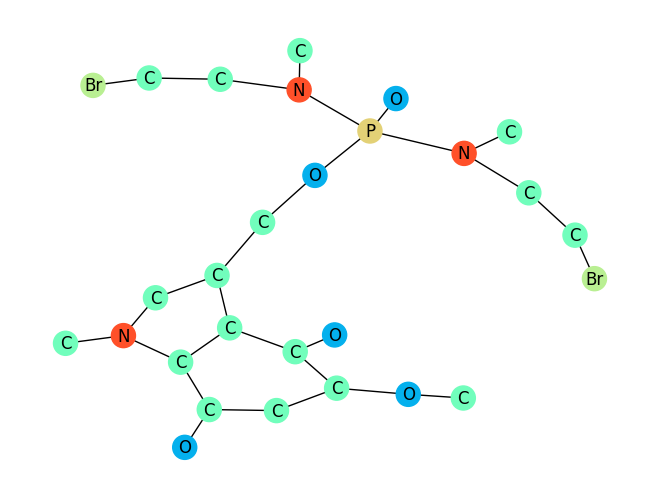

In [7]:
plt.clf()
visualize(train_data[0])

### preprocessing

In [8]:
max_vocab = 500
max_len = 100


# build vocabulary from training set
#convert nodes to
all_nodes = [s[0] for s in train_data]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [9]:
random.seed(0)

def prepare_single_batch(samples):
    """
    this function to convert the nodes to sequences, prepare the edges, and mapping nodes to graphs

    """
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


#function to organize the input and output data into batches for fit function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

In [10]:
# showing one batch:
for train_batch in gen_batch(train_data, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[21  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  4  4  2  2  2  2  2  2
  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2
  2  2  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
edges
[[  0   1]
 [  0   5]
 [  0   6]
 [  0   7]
 [  1   4]
 [  2   4]
 [  3   8]
 [  4   9]
 [  5  11]
 [  6  12]
 [  7  13]
 [  8   9]
 [  8  10]
 [ 10  14]
 [ 10  15]
 [ 11  19]
 [ 12  20]
 [ 13  21]
 [ 14  16]
 [ 15  17]
 

### functions to build, compile, train, and visualize the data

In [11]:
def build_GCN(hidden_dim = 32 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2):
    """
    function to build GCN network with selecting the hyperparameters for the network
    
    param:
    
    hidden_dim (int): the size of the output of all message passing layers.
    message_calculation_class: configures the message passing style.
    dense_intermediate_layer_activation:  configures the activation function used after the dense layer
    num_layers (int): sets the number of GNN message passing layers (usually, a number between 2 and 16)
    
    return:
    
    the model
    
    """
    keras.backend.clear_session()
    #the input nodes
    data = keras.Input(batch_shape=(None,))
    # the first dim is different to the previous one. it is the total number of edges in this batch
    #edges
    edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
    #mapping nodes to graphs
    node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
    embeded = Embedding(tokenizer.num_words, 20)(data)
    # number of graphs (number of samples)
    num_graph = tf.reduce_max(node2graph)+1
    
    #add input to graph neural network
    gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
    )
    
    # https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
    #get the default values for graph neural network
    params = GNN.get_default_hyperparameters()
    #set the hyperparameters with values
    params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = hidden_dim, message_calculation_class, dense_intermediate_layer_activation, num_layers
    #if message_calculation_class was RGAT set num_heads to a value to prevent the error.
    if params['message_calculation_class'] == 'RGAT':
        params['num_heads'] = 32
    else:
        pass
    print(f"message passing style used in this model will be {params['message_calculation_class']}\n")
    gnn_layer = GNN(params)
    #extract the output data
    gnn_out = gnn_layer(gnn_input)

    print('gnn_out', gnn_out)

    # https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
    #reduce the out using segment mean
    avg = segment_mean(
        data=gnn_out,
        segment_ids=node2graph
    )
    print('mean:', avg)

    #output layer
    pred = Dense(1, activation='sigmoid')(avg)
    print('pred:', pred)

    model = Model(
        inputs={
            'data': data,
            'edges': edge,
            'node2grah': node2graph,
        },
        outputs=pred
    )

    return model

In [12]:
def compile_and_train_model(model, training_data, validation_data , optimizer, loss, metric, batch_size = 64, epochs = 50):
    """
    function to compile and train the model
    
    params:
    
    model: tensorflow model
    
    training_data (numpy or pandas): your training data
    validation_data (numpy or pandas): your validation data
    
    optimizer: the optimizer used to convergence
    loss: loss function
    metric: to evaluate the model
    batch_size: to use it in the fit function
    epochs: number of epochs to train the model.
    
    return
    
    trained_model
    the validation and training scores
    """
    #define the model properties
    model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics = metric 
    )
    #early stopping tracer to prevent the overfitting
    early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

    batch_size = batch_size
    num_batchs = math.ceil(len(training_data) / batch_size)
    num_batchs_validation = math.ceil(len(training_data) / batch_size)
    #to run the model on gpu, unhash if your run time is GPU
    #tf.debugging.set_log_device_placement(True)

    #start training the batches
    history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=epochs,
    validation_data=gen_batch(
        validation_data, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
    )
    
    return model, history

In [13]:
def plot_performance(history):
    """
    function to plot training loss vs validation loss and training roc_auc score vs validation roc_auc.<br>
    
    params:
    
    history: model.fit object
    
    return:
    
    None
    """
    val_loss_per_epoch = history.history['val_loss']
    loss_per_epoch = history.history['loss']
    val_accuracy_per_epoch = history.history['val_auc']
    accuracy_per_epoch = history.history['auc']
    plt.figure(figsize=(8,8))
    plt.title(f"Training loss & validation loss with batch size 64")
    plt.xlabel('epoch')
    plt.ylabel('loss function')
    plt.plot(np.arange(1,len(val_loss_per_epoch)+1),val_loss_per_epoch,label=f"validation loss")
    plt.plot(np.arange(1,len(loss_per_epoch)+1),loss_per_epoch,label = f"training loss")
    plt.legend(loc="upper left")
    plt.show()
    plt.figure(figsize=(8,8))
    plt.title(f"Training ROC_AUC score & validation ROC_AUC score with batch size 64")
    plt.xlabel('epoch')
    plt.ylabel('ROC_AUC score')
    plt.plot(np.arange(1,len(val_accuracy_per_epoch)+1),val_accuracy_per_epoch,label="validation ROC_AUC")
    plt.plot(np.arange(1,len(accuracy_per_epoch)+1),accuracy_per_epoch,label = "training ROC_AUC")
    plt.legend(loc="upper left")
    plt.show()

In [14]:
def predict_and_make_submission_file(model, file_name ,batch_size = 64):
    """
    function to predict and make the submission file for kaggle platform
    
    params:
    model: trained tensorflow model
    file_name: submission file name end with csv extension
    batch_size: predict the sample in batches
    
    return
    
    predicted values.
    
    """
    #predict the testing_set
    y_pred = model.predict(
        gen_batch(test_data, batch_size = batch_size, shuffle=False)
    )
    print(y_pred.shape)
    y_pred = np.reshape(y_pred, -1)
    
    print(len(y_pred))
    #make submmision file to evaluate the model based on kaggle score. 
    submission = pd.DataFrame({'label':y_pred})
    submission.index.name = 'id'
    submission.to_csv(file_name)
    
    return y_pred

### first trial

* in this trial i set the "message_calculation_class" as a 'GGNN' that Compute new graph states by neural message passing and gated units on the nodes using balanced and preprocessed data.
* and set the hidden_dim as 32 then used the tanh activation as the dense_intermediate_layer_activation.


In [33]:
model1 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model1.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

In [36]:
model1, history1 = compile_and_train_model(model1, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70
633/633 [==============================] - 57s 86ms/step - loss: 0.6420 - auc: 0.6745 - val_loss: 0.6290 - val_auc: 0.6998
Epoch 2/70
633/633 [==============================] - 53s 83ms/step - loss: 0.6080 - auc: 0.7312 - val_loss: 0.5892 - val_auc: 0.7581
Epoch 3/70
633/633 [==============================] - 45s 71ms/step - loss: 0.5832 - auc: 0.7639 - val_loss: 0.5787 - val_auc: 0.7804
Epoch 4/70
633/633 [==============================] - 45s 71ms/step - loss: 0.5750 - auc: 0.7725 - val_loss: 0.5699 - val_auc: 0.7872
Epoch 5/70
633/633 [==============================] - 45s 71ms/step - loss: 0.5670 - auc: 0.7811 - val_loss: 0.5739 - val_auc: 0.7964
Epoch 6/70
633/633 [==============================] - 54s 85ms/step - loss: 0.5624 - auc: 0.7867 - val_loss: 0.5550 - val_auc: 0.7972
Epoch 7/70
633/633 [==============================] - 53s 83ms/step - loss: 0.5575 - auc: 0.7916 - val_loss: 0.5498 - val_auc: 0.8022
Epoch 8/70
633/633 [==============================] - 54s 86ms

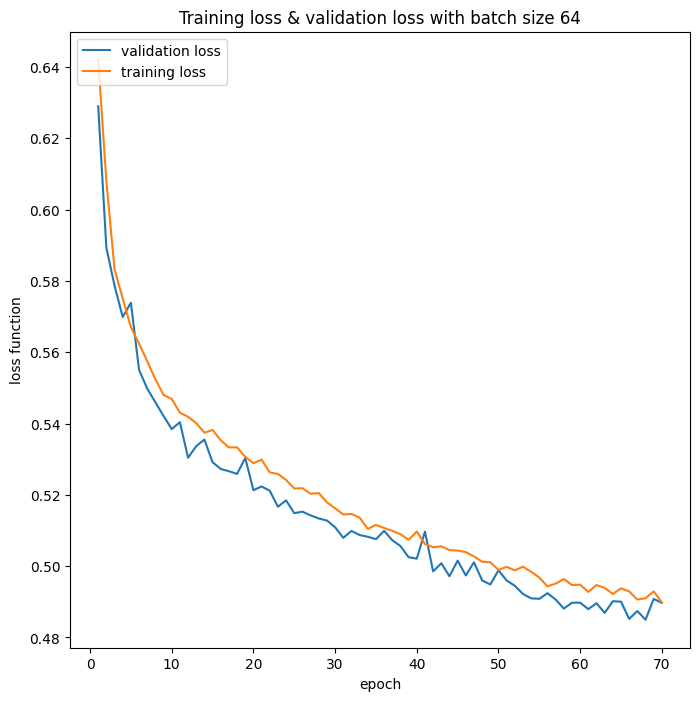

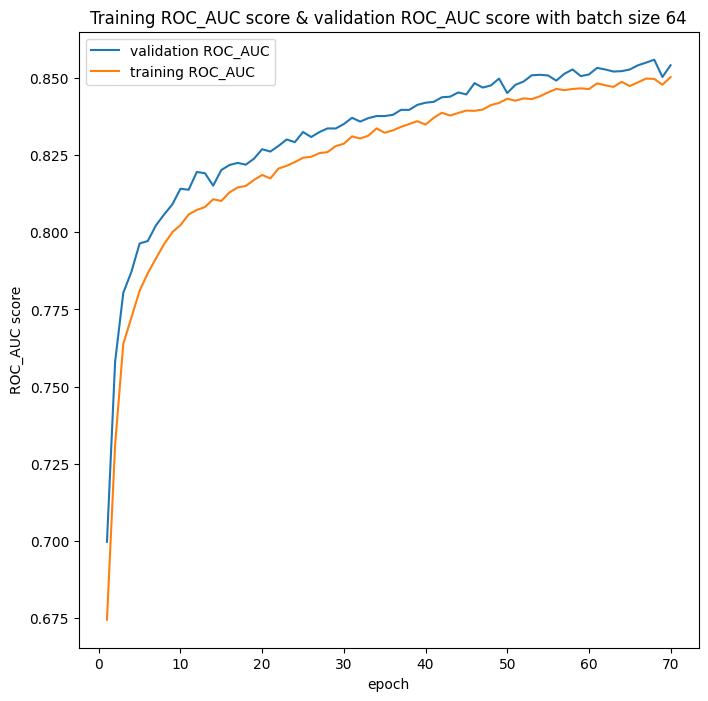

In [38]:
plot_performance(history1)

In [41]:
y_pred1 = predict_and_make_submission_file(model1,'sumbission_file_1.csv',batch_size = 64)
print(y_pred1)

193/193 [==============================] - 4s 19ms/step
(12326, 1)
12326
[0.50063264 0.32500723 0.30290717 ... 0.25941327 0.1626405  0.7880153 ]


### observations:
* the model has an accuracy of 0.8503
* and a validation accuracy of 0.8541
* in kaggle public accuracy of 0.84072

so i observed that No overfitting happened here the test score is near to the validation score, maybe the increase in the model complexity of the model will be followed by an increase in performance, and that what will we do in the next trial.

-------------------------------------------------------------------------------

### second trail

* In this trial I decided to use the same configuration of the message passing style as the previous model but with more neurons in the hidden layer, to see if more neurons in the hidden layer would improve the results or not.
* set "message_calculation_class" as a 'GGNN'.
* set the hidden_dim as 64 then used the tanh activation as the dense_intermediate_layer_activation.

In [15]:
model2 = build_GCN(hidden_dim = 64 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model2.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

In [16]:
model2, history2 = compile_and_train_model(model2, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70
633/633 [==============================] - 21s 23ms/step - loss: 0.6374 - auc: 0.6827 - val_loss: 0.6179 - val_auc: 0.7254
Epoch 2/70
633/633 [==============================] - 10s 16ms/step - loss: 0.5989 - auc: 0.7456 - val_loss: 0.5904 - val_auc: 0.7692
Epoch 3/70
633/633 [==============================] - 12s 18ms/step - loss: 0.5780 - auc: 0.7712 - val_loss: 0.5656 - val_auc: 0.7827
Epoch 4/70
633/633 [==============================] - 12s 19ms/step - loss: 0.5682 - auc: 0.7828 - val_loss: 0.5542 - val_auc: 0.7926
Epoch 5/70
633/633 [==============================] - 16s 25ms/step - loss: 0.5611 - auc: 0.7906 - val_loss: 0.5546 - val_auc: 0.7955
Epoch 6/70
633/633 [==============================] - 10s 16ms/step - loss: 0.5546 - auc: 0.7969 - val_loss: 0.5464 - val_auc: 0.8019
Epoch 7/70
633/633 [==============================] - 10s 16ms/step - loss: 0.5517 - auc: 0.8025 - val_loss: 0.5442 - val_auc: 0.8053
Epoch 8/70
633/633 [==============================] - 10s 16ms

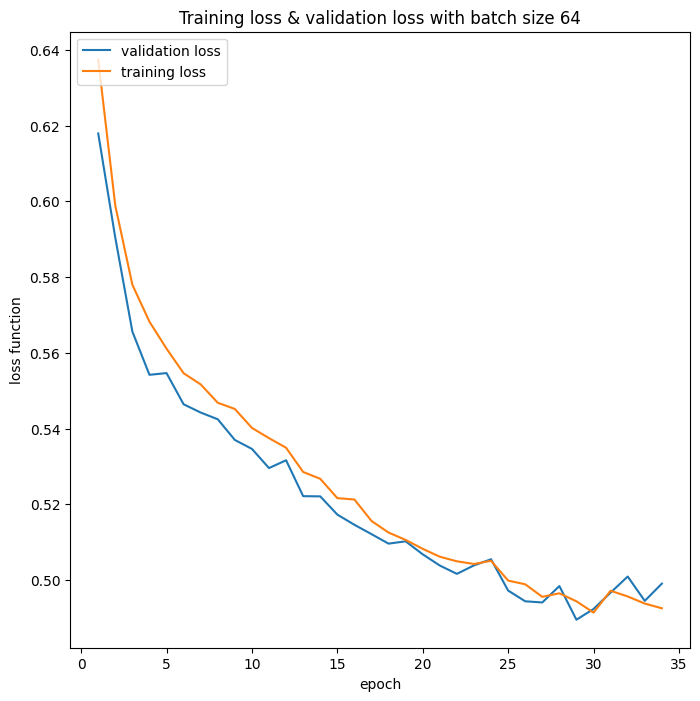

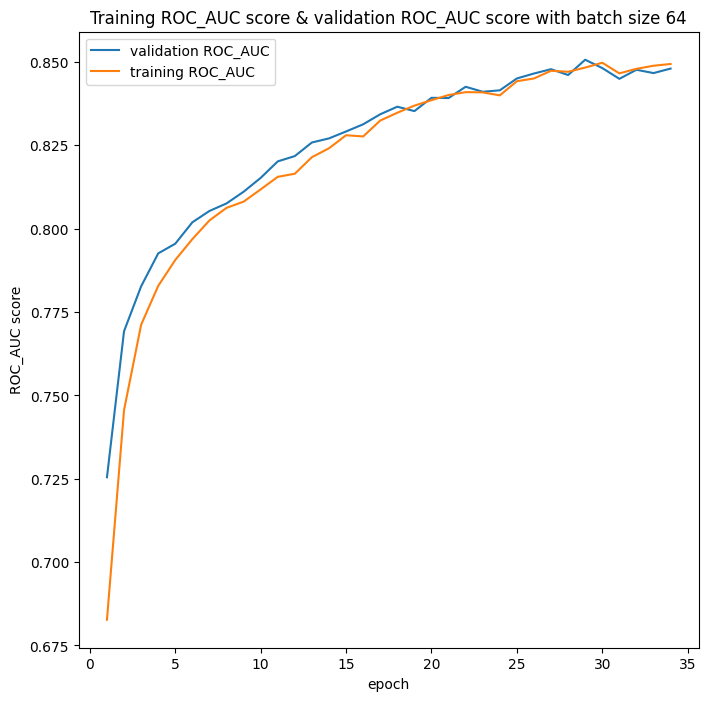

In [17]:
plot_performance(history2)

In [18]:
y_pred2 = predict_and_make_submission_file(model2,'sumbission_file_2.csv',batch_size = 64)
print(y_pred2)

193/193 [==============================] - 1s 5ms/step
(12326, 1)
12326
[0.37718865 0.2731267  0.21229492 ... 0.3689944  0.20090249 0.6655303 ]


### observations:
* the model has an accuracy of 0.8494
* and a validation accuracy of 0.8480
* in kaggle public accuracy of 0.82935

so i observed that Increasing the number of the hidden layer neurons here decresses the ROC AUC score a little bit in both leaderboards and I think that is because of the increase in the number of trainable parameters, and note that there was a small overfit happen here.

-------------------------------------------------------------------------------

### third trial

* Here, I just modified the message passing style setup for the RGCN; our model is largely motivated as an extension of GCNs that operate on local graph neighbourhoods to large-scale relational data to large-scale relational data (a linear transformation with a weight matrix); This kind of transformation has been shown to be very efficient at gathering and encoding features from local, structured neighbourhoods, and has resulted in significant advancements in fields like graph classification. For this kind of problem, I would see if this kind of message pass style would improve accuracy or the GGNN is better for this kind of problems.

In [19]:
model3 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'RGCN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)
model3.summary()

message passing style used in this model will be RGCN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

In [20]:
model3, history3 = compile_and_train_model(model3, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)


Epoch 1/70
633/633 [==============================] - 17s 24ms/step - loss: 0.6555 - auc: 0.6523 - val_loss: 0.6415 - val_auc: 0.6852
Epoch 2/70
633/633 [==============================] - 9s 15ms/step - loss: 0.6382 - auc: 0.6827 - val_loss: 0.6316 - val_auc: 0.7046
Epoch 3/70
633/633 [==============================] - 11s 17ms/step - loss: 0.6261 - auc: 0.7048 - val_loss: 0.6107 - val_auc: 0.7381
Epoch 4/70
633/633 [==============================] - 11s 17ms/step - loss: 0.6069 - auc: 0.7377 - val_loss: 0.5989 - val_auc: 0.7524
Epoch 5/70
633/633 [==============================] - 12s 19ms/step - loss: 0.6016 - auc: 0.7452 - val_loss: 0.5972 - val_auc: 0.7517
Epoch 6/70
633/633 [==============================] - 10s 16ms/step - loss: 0.6004 - auc: 0.7455 - val_loss: 0.5955 - val_auc: 0.7543
Epoch 7/70
633/633 [==============================] - 9s 14ms/step - loss: 0.5993 - auc: 0.7462 - val_loss: 0.5937 - val_auc: 0.7524
Epoch 8/70
633/633 [==============================] - 18s 28ms/s

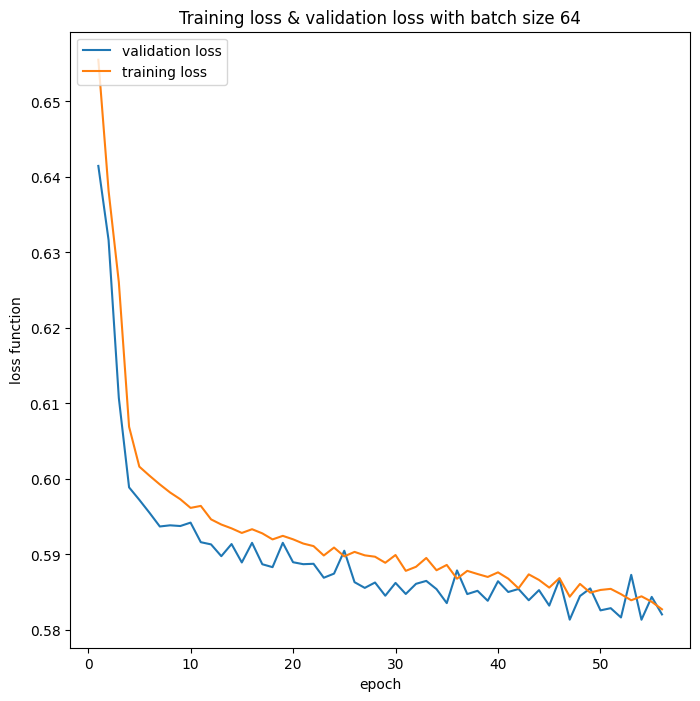

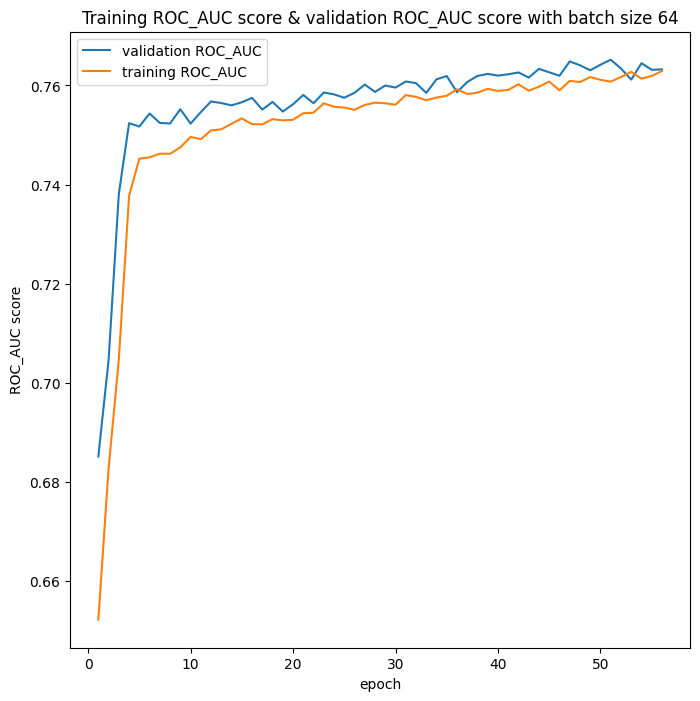

In [21]:
plot_performance(history3)

In [22]:
y_pred3 = predict_and_make_submission_file(model3,'sumbission_file_3.csv',batch_size = 64)
print(y_pred3)

193/193 [==============================] - 1s 4ms/step
(12326, 1)
12326
[0.6493579  0.46348    0.321076   ... 0.28317752 0.5245249  0.6727945 ]


### observations:
* the model has an accuracy of 0.7629
* and a validation accuracy of 0.7632
* in kaggle public accuracy of 0.74724

so i observed that Using this message passing style didn't help at all, GGNN was too much better the model and it overfits after training on the half epochs, so I don't recommend it for this kind of problem.

-------------------------------------------------------------------------------

### fourth trial

* In this trial I decided to use the same configuration of the message passing style as the previous model but with more neurons in the hidden layer, to see if more neurons in the hidden layer would improve the results or not.
* the message passing style setup for the RGCN
* set the hidden_dim as 64 then used the tanh activation as the dense_intermediate_layer_activation.

In [23]:
model4 = build_GCN(hidden_dim = 64 ,message_calculation_class = 'RGCN' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)
model4.summary()

message passing style used in this model will be RGCN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

In [24]:
model4, history4 = compile_and_train_model(model4, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)


Epoch 1/70
633/633 [==============================] - 14s 20ms/step - loss: 0.6504 - auc: 0.6582 - val_loss: 0.6370 - val_auc: 0.6945
Epoch 2/70
633/633 [==============================] - 9s 14ms/step - loss: 0.6360 - auc: 0.6835 - val_loss: 0.6313 - val_auc: 0.6931
Epoch 3/70
633/633 [==============================] - 8s 12ms/step - loss: 0.6312 - auc: 0.6934 - val_loss: 0.6258 - val_auc: 0.7167
Epoch 4/70
633/633 [==============================] - 11s 17ms/step - loss: 0.6166 - auc: 0.7231 - val_loss: 0.6019 - val_auc: 0.7506
Epoch 5/70
633/633 [==============================] - 9s 14ms/step - loss: 0.6013 - auc: 0.7452 - val_loss: 0.5952 - val_auc: 0.7539
Epoch 6/70
633/633 [==============================] - 10s 16ms/step - loss: 0.5984 - auc: 0.7479 - val_loss: 0.5934 - val_auc: 0.7522
Epoch 7/70
633/633 [==============================] - 10s 15ms/step - loss: 0.5977 - auc: 0.7476 - val_loss: 0.5936 - val_auc: 0.7520
Epoch 8/70
633/633 [==============================] - 10s 17ms/st

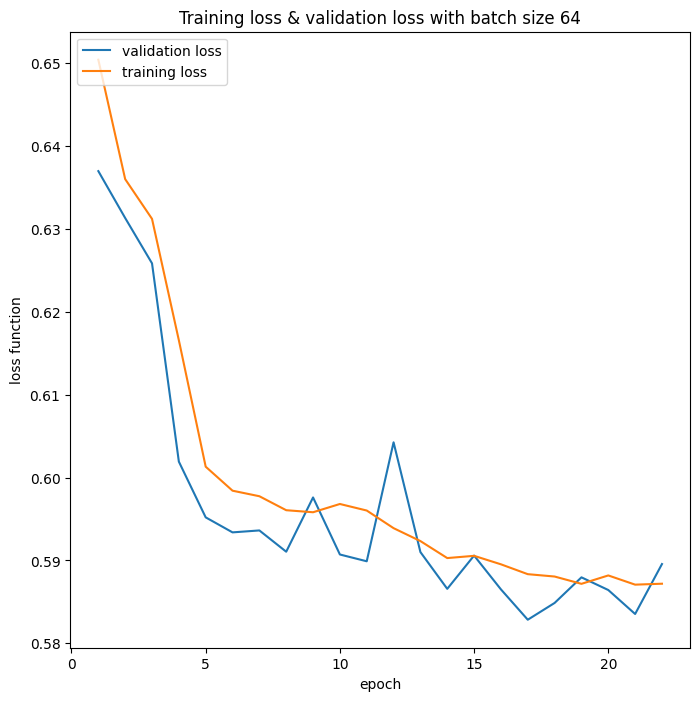

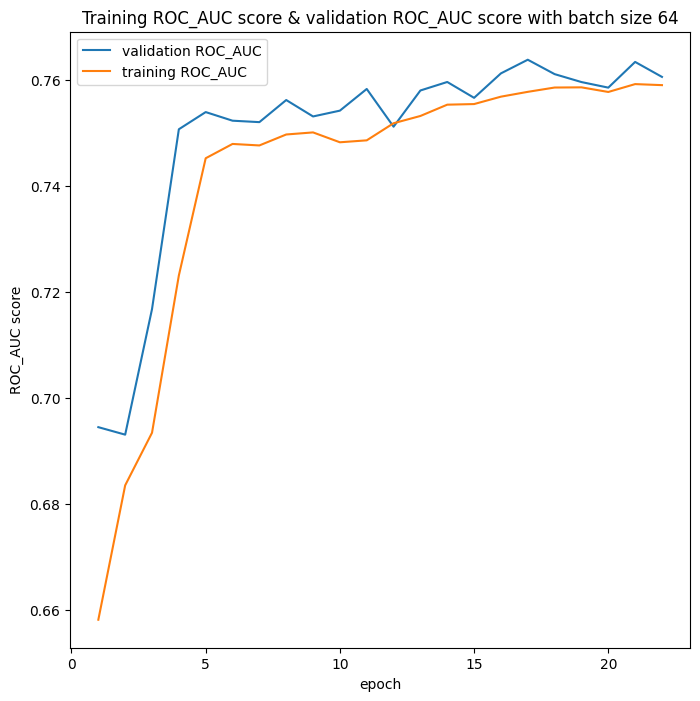

In [25]:
plot_performance(history4)

In [26]:
y_pred4 = predict_and_make_submission_file(model4,'sumbission_file_4.csv',batch_size = 64)
print(y_pred4)

193/193 [==============================] - 1s 4ms/step
(12326, 1)
12326
[0.6092855  0.4109271  0.27717087 ... 0.24542509 0.31948894 0.6208537 ]


### observations:
* the model has an accuracy of 0.7589
* and a validation accuracy of 0.7605
* in kaggle public accuracy of 0.74701

so i observed that Adding fully connect MLP in this archictechture helped a little bit than previous trial but not too much and I wouldn't recommend this model because it starts to overfit after 22 epochs and it's much worest than first and second trial.

-------------------------------------------------------------------------------

### fifth trial

* In this trial, I also altered the message passing style option to GNN_Edge_MPL. I chose it to compare its performance to that of the RGCN and I left the other hyperparameters at their default values to see if doing so would improve the results and performance. It has the same properties as the RGCN, but it is a variant of the RGCN in which messages on edges are computed using full MLPs, not just a single layer.

In [27]:
model5 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'GNN_Edge_MLP' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model5.summary()

message passing style used in this model will be GNN_Edge_MLP

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)     

In [28]:
model5, history5 = compile_and_train_model(model5, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)


Epoch 1/70
633/633 [==============================] - 12s 16ms/step - loss: 0.6524 - auc: 0.6579 - val_loss: 0.6327 - val_auc: 0.6931
Epoch 2/70
633/633 [==============================] - 10s 16ms/step - loss: 0.6232 - auc: 0.7116 - val_loss: 0.6096 - val_auc: 0.7419
Epoch 3/70
633/633 [==============================] - 10s 15ms/step - loss: 0.6073 - auc: 0.7360 - val_loss: 0.6014 - val_auc: 0.7480
Epoch 4/70
633/633 [==============================] - 11s 17ms/step - loss: 0.6037 - auc: 0.7407 - val_loss: 0.5984 - val_auc: 0.7485
Epoch 5/70
633/633 [==============================] - 9s 14ms/step - loss: 0.6033 - auc: 0.7414 - val_loss: 0.6021 - val_auc: 0.7482
Epoch 6/70
633/633 [==============================] - 10s 16ms/step - loss: 0.6019 - auc: 0.7416 - val_loss: 0.5980 - val_auc: 0.7508
Epoch 7/70
633/633 [==============================] - 7s 12ms/step - loss: 0.6018 - auc: 0.7432 - val_loss: 0.5976 - val_auc: 0.7495
Epoch 8/70
633/633 [==============================] - 9s 14ms/st

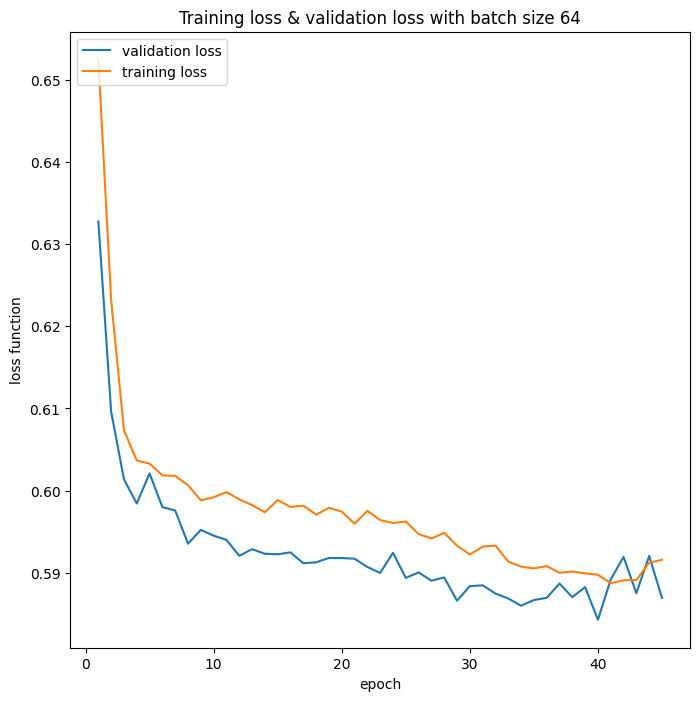

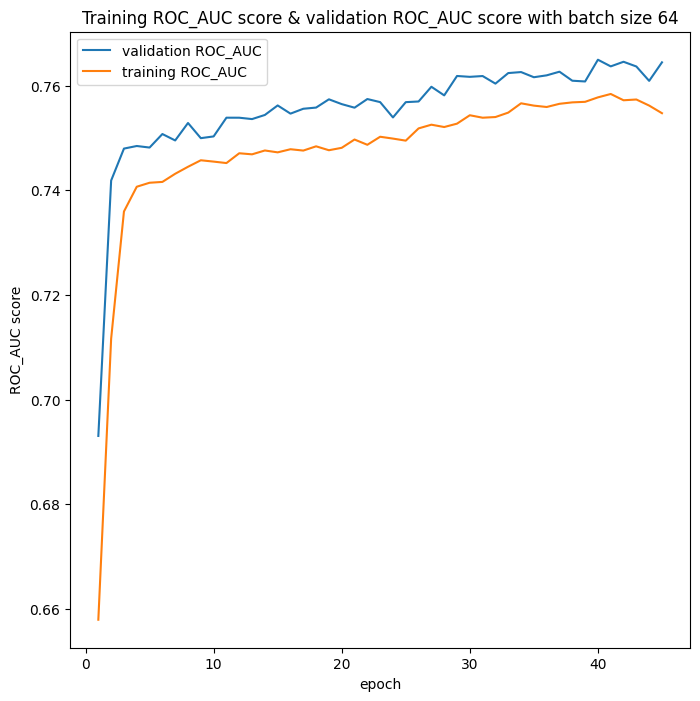

In [29]:
plot_performance(history5)

In [30]:
y_pred5 = predict_and_make_submission_file(model5,'sumbission_file_5.csv',batch_size = 64)
print(y_pred5)

193/193 [==============================] - 1s 6ms/step
(12326, 1)
12326
[0.57573277 0.41098154 0.2932176  ... 0.27361688 0.3472665  0.5671571 ]


### observations:
* the model has an accuracy of 0.7547
* and a validation accuracy of 0.7645
* in kaggle public accuracy of 0.7394

so i observed that the model start overfitting and GNN_Edge_MPL didn't help in this case

-------------------------------------------------------------------------------

# sixth trial

* In this trial I decided to use the same configuration of the message passing style as the previous model but with more neurons in the hidden layer, to see if more neurons in the hidden layer would improve the results or not.
* the message passing style setup for the GNN_Edge_MLP
* set the hidden_dim as 64 then used the tanh activation as the dense_intermediate_layer_activation.

In [31]:
model6 = build_GCN(hidden_dim = 64 ,message_calculation_class = 'GNN_Edge_MLP' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model6.summary()

message passing style used in this model will be GNN_Edge_MLP

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)     

In [32]:
model6, history6 = compile_and_train_model(model6, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)


Epoch 1/70
633/633 [==============================] - 12s 16ms/step - loss: 0.6525 - auc: 0.6566 - val_loss: 0.6382 - val_auc: 0.6873
Epoch 2/70
633/633 [==============================] - 10s 16ms/step - loss: 0.6353 - auc: 0.6847 - val_loss: 0.6290 - val_auc: 0.7070
Epoch 3/70
633/633 [==============================] - 11s 17ms/step - loss: 0.6282 - auc: 0.7021 - val_loss: 0.6275 - val_auc: 0.7203
Epoch 4/70
633/633 [==============================] - 11s 18ms/step - loss: 0.6196 - auc: 0.7148 - val_loss: 0.6101 - val_auc: 0.7361
Epoch 5/70
633/633 [==============================] - 9s 14ms/step - loss: 0.6100 - auc: 0.7302 - val_loss: 0.6070 - val_auc: 0.7462
Epoch 6/70
633/633 [==============================] - 8s 12ms/step - loss: 0.6007 - auc: 0.7444 - val_loss: 0.5930 - val_auc: 0.7548
Epoch 7/70
633/633 [==============================] - 11s 18ms/step - loss: 0.5966 - auc: 0.7499 - val_loss: 0.5924 - val_auc: 0.7573
Epoch 8/70
633/633 [==============================] - 9s 14ms/st

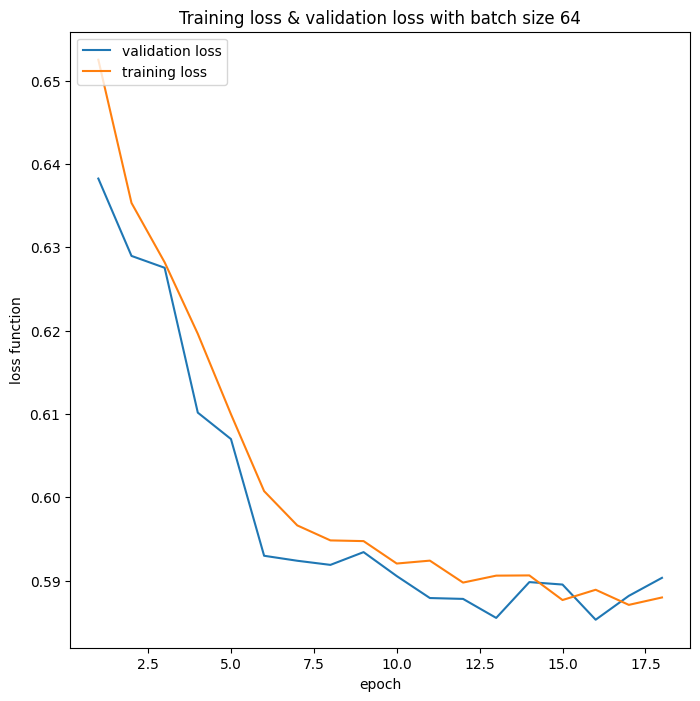

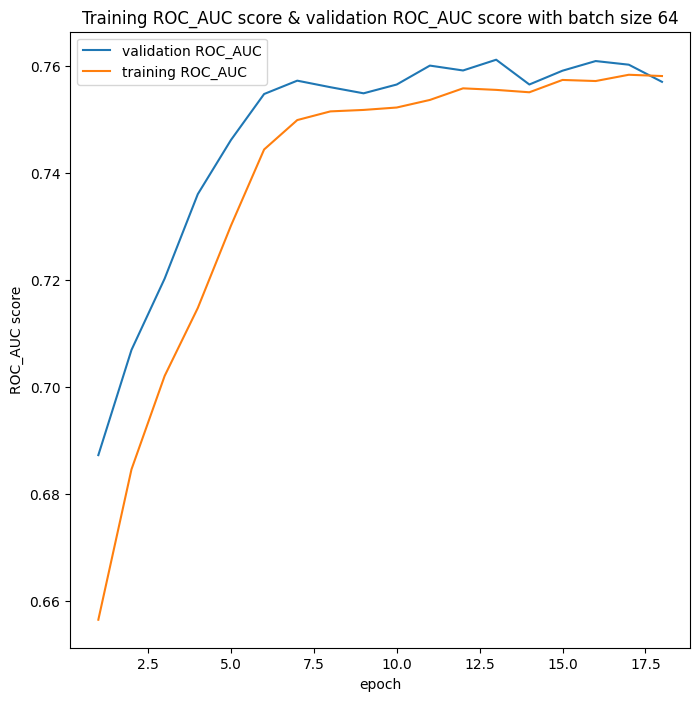

In [33]:
plot_performance(history6)

In [34]:
y_pred6 = predict_and_make_submission_file(model6,'sumbission_file_6.csv',batch_size = 64)
print(y_pred6)

193/193 [==============================] - 1s 4ms/step
(12326, 1)
12326
[0.5818638  0.44906664 0.35417014 ... 0.2970434  0.5814869  0.6164434 ]


### observations:
* the model has an accuracy of 0.7581
* and a validation accuracy of 0.7570
* in kaggle public accuracy of 0.75015

so i observed that adding more hidden units decreased the overfitting but still this model still has less accuracy than the first and the second trails

-------------------------------------------------------------------------------

### seventh trial

* I modified the message passing style option to RGAT (Relational Graph Attention Networks), I chose to leave the hyperparameters here as default.This neural network uses masked self-attentional layers to address the shortcomings of earlier methods based on graph convolutions or their approximations. It works with graph-structured input. By stacking layers, we enable (implicitly) providing various weights to various nodes in a neighbourhood without requiring any type of expensive matrix operation (such as inversion) or relying on knowledge of the graph structure. I use it to see if it'll help or not.

In [35]:
model7 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'RGAT' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model7.summary()

message passing style used in this model will be RGAT

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

In [36]:
model7, history7 = compile_and_train_model(model7, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)


Epoch 1/70
633/633 [==============================] - 49s 62ms/step - loss: 0.6555 - auc: 0.6524 - val_loss: 0.6362 - val_auc: 0.6998
Epoch 2/70
633/633 [==============================] - 40s 64ms/step - loss: 0.6183 - auc: 0.7229 - val_loss: 0.5971 - val_auc: 0.7556
Epoch 3/70
633/633 [==============================] - 40s 63ms/step - loss: 0.5967 - auc: 0.7519 - val_loss: 0.5909 - val_auc: 0.7588
Epoch 4/70
633/633 [==============================] - 37s 58ms/step - loss: 0.5932 - auc: 0.7547 - val_loss: 0.5896 - val_auc: 0.7618
Epoch 5/70
633/633 [==============================] - 38s 60ms/step - loss: 0.5906 - auc: 0.7575 - val_loss: 0.5868 - val_auc: 0.7608
Epoch 6/70
633/633 [==============================] - 36s 56ms/step - loss: 0.5905 - auc: 0.7563 - val_loss: 0.5836 - val_auc: 0.7635
Epoch 7/70
633/633 [==============================] - 41s 65ms/step - loss: 0.5885 - auc: 0.7579 - val_loss: 0.5834 - val_auc: 0.7643
Epoch 8/70
633/633 [==============================] - 40s 64ms

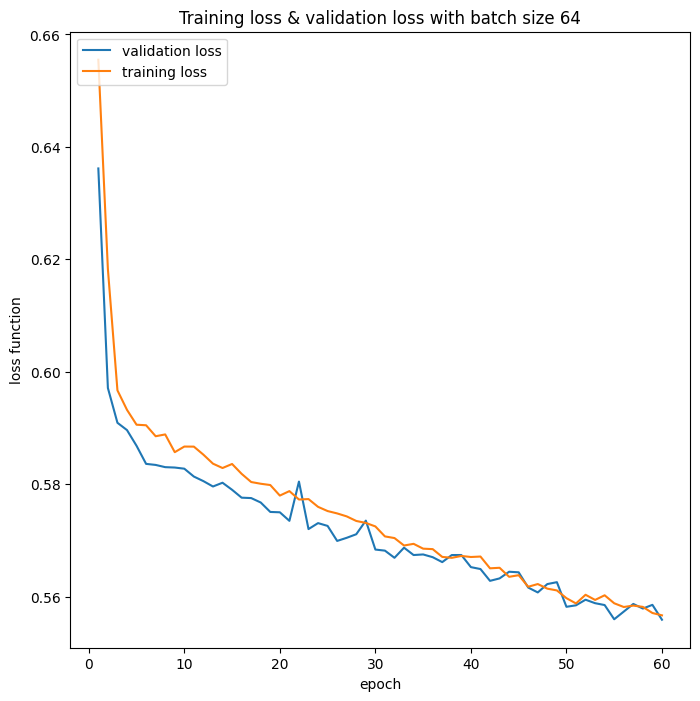

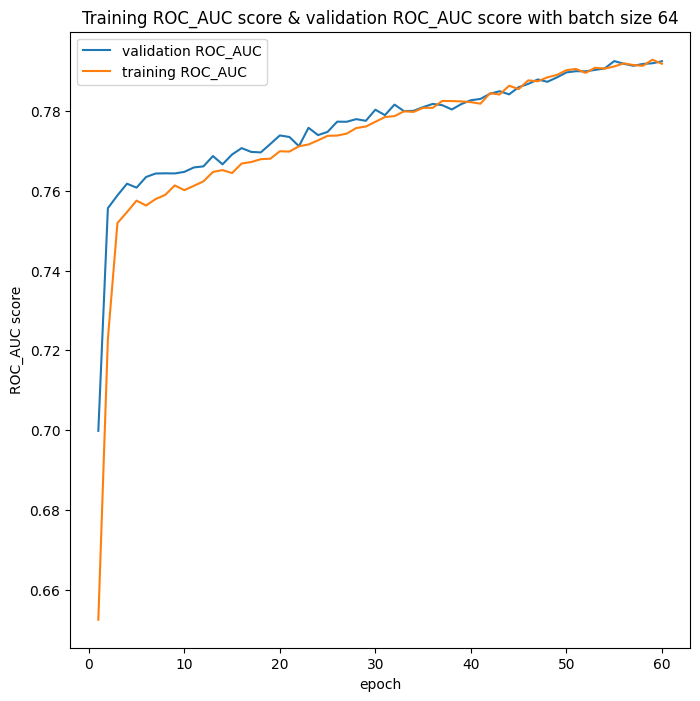

In [37]:
plot_performance(history7)

In [38]:
y_pred7 = predict_and_make_submission_file(model7,'sumbission_file_7.csv',batch_size = 64)
print(y_pred7)

193/193 [==============================] - 3s 12ms/step
(12326, 1)
12326
[0.5150304  0.32077625 0.28140664 ... 0.2201304  0.34763822 0.64084125]


### observations:
* the model has an accuracy of 0.7918
* and a validation accuracy of 0.7925
* in kaggle public accuracy of 0.78692

so i observed that it was better than models that used RGC and GNN_Edge_MLP as message_calculation_class hyperparameter but it's still much worest than previous model, the model start to overfit after 30 epochs.

-------------------------------------------------------------------------------

### Eighth trial

* In this trial I decided to use the same configuration of the message passing style as the previous model but with more neurons in the hidden layer, to see if more neurons in the hidden layer would improve the results or not.
* the message passing style setup for the RGAT.
* set the hidden_dim as 64 then used the tanh activation as the dense_intermediate_layer_activation.

In [39]:
model8 = build_GCN(hidden_dim = 64 ,message_calculation_class = 'RGAT' ,dense_intermediate_layer_activation = 'tanh', num_layers = 2)

model8.summary()

message passing style used in this model will be RGAT

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

In [40]:
model8, history8 = compile_and_train_model(model8, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)


Epoch 1/70
633/633 [==============================] - 54s 70ms/step - loss: 0.6500 - auc: 0.6620 - val_loss: 0.6312 - val_auc: 0.6998
Epoch 2/70
633/633 [==============================] - 37s 59ms/step - loss: 0.6219 - auc: 0.7142 - val_loss: 0.6026 - val_auc: 0.7509
Epoch 3/70
633/633 [==============================] - 42s 67ms/step - loss: 0.5919 - auc: 0.7586 - val_loss: 0.5828 - val_auc: 0.7679
Epoch 4/70
633/633 [==============================] - 41s 65ms/step - loss: 0.5832 - auc: 0.7676 - val_loss: 0.5798 - val_auc: 0.7723
Epoch 5/70
633/633 [==============================] - 39s 62ms/step - loss: 0.5777 - auc: 0.7733 - val_loss: 0.5706 - val_auc: 0.7794
Epoch 6/70
633/633 [==============================] - 38s 60ms/step - loss: 0.5723 - auc: 0.7771 - val_loss: 0.5719 - val_auc: 0.7798
Epoch 7/70
633/633 [==============================] - 38s 60ms/step - loss: 0.5708 - auc: 0.7792 - val_loss: 0.5669 - val_auc: 0.7824
Epoch 8/70
633/633 [==============================] - 37s 59ms

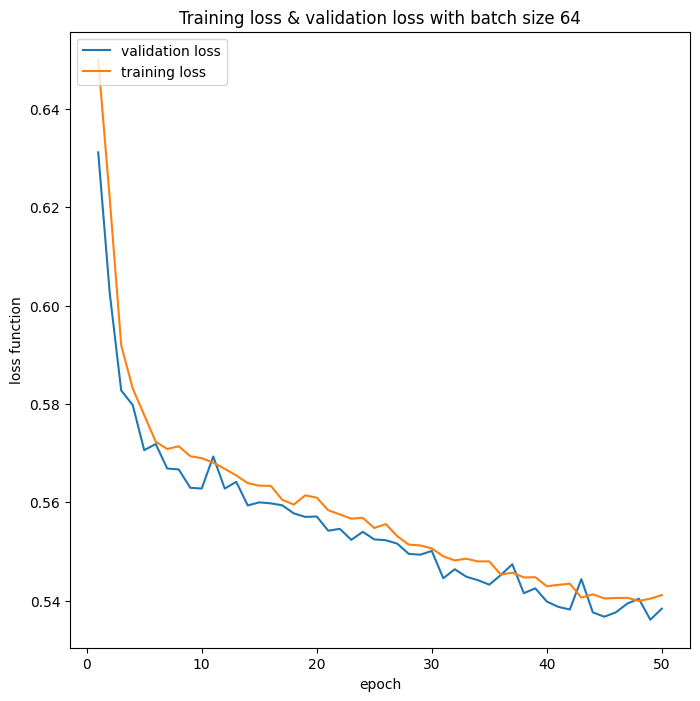

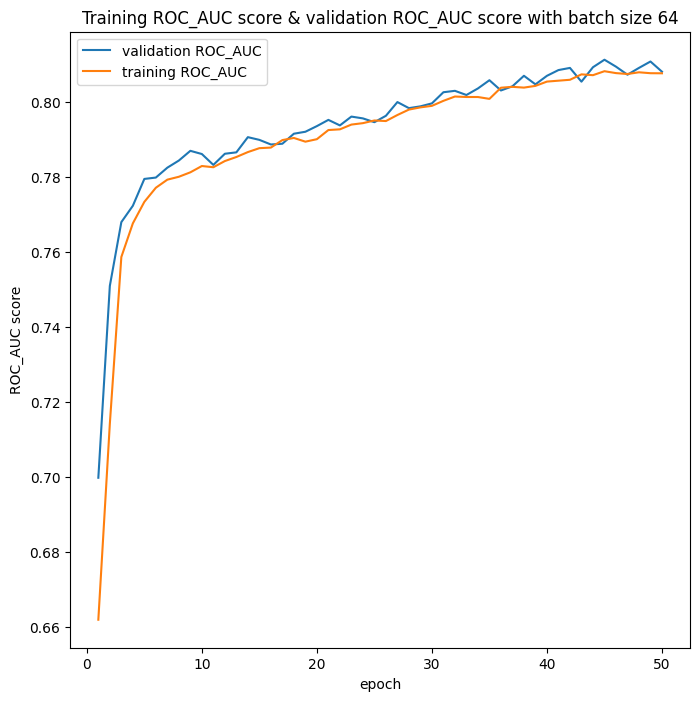

In [41]:
plot_performance(history8)

In [42]:
y_pred8 = predict_and_make_submission_file(model8,'sumbission_file_8.csv',batch_size = 64)
print(y_pred8)

193/193 [==============================] - 2s 10ms/step
(12326, 1)
12326
[0.5513742  0.3642237  0.2829663  ... 0.23967725 0.43652433 0.8332737 ]


### observations:
* the model has an accuracy of 0.8076
* and a validation accuracy of 0.8080
* in kaggle public accuracy of 0.80158

so i observed that adding more units prevents the overfitting and increase the accuracy but it still less than the first two trials

-------------------------------------------------------------------------------

### ninth trial 


* I used GGNN again as message_calculation_class hyperparameter because it's the one which gave me best results but I'll change the number of layer from 4 (default value) to 12 to see if this would imorove the accuracy or it will produce overfitting.
* I changed the intermediate layer activation function from tanh to relu to see if it will suffer from gradient vanishing or not.

In [43]:
model9 = build_GCN(hidden_dim = 32 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'relu', num_layers = 12)

model9.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

In [44]:
model9, history9 = compile_and_train_model(model9, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70
633/633 [==============================] - 63s 65ms/step - loss: 0.6380 - auc: 0.6807 - val_loss: 0.5758 - val_auc: 0.7658
Epoch 2/70
633/633 [==============================] - 42s 66ms/step - loss: 0.5600 - auc: 0.7831 - val_loss: 0.5189 - val_auc: 0.8256
Epoch 3/70
633/633 [==============================] - 41s 65ms/step - loss: 0.5089 - auc: 0.8300 - val_loss: 0.4729 - val_auc: 0.8583
Epoch 4/70
633/633 [==============================] - 40s 63ms/step - loss: 0.4712 - auc: 0.8574 - val_loss: 0.4586 - val_auc: 0.8751
Epoch 5/70
633/633 [==============================] - 37s 59ms/step - loss: 0.4376 - auc: 0.8792 - val_loss: 0.4235 - val_auc: 0.8918
Epoch 6/70
633/633 [==============================] - 40s 63ms/step - loss: 0.4082 - auc: 0.8958 - val_loss: 0.3877 - val_auc: 0.9072
Epoch 7/70
633/633 [==============================] - 39s 62ms/step - loss: 0.3876 - auc: 0.9067 - val_loss: 0.3855 - val_auc: 0.9111
Epoch 8/70
633/633 [==============================] - 40s 64ms

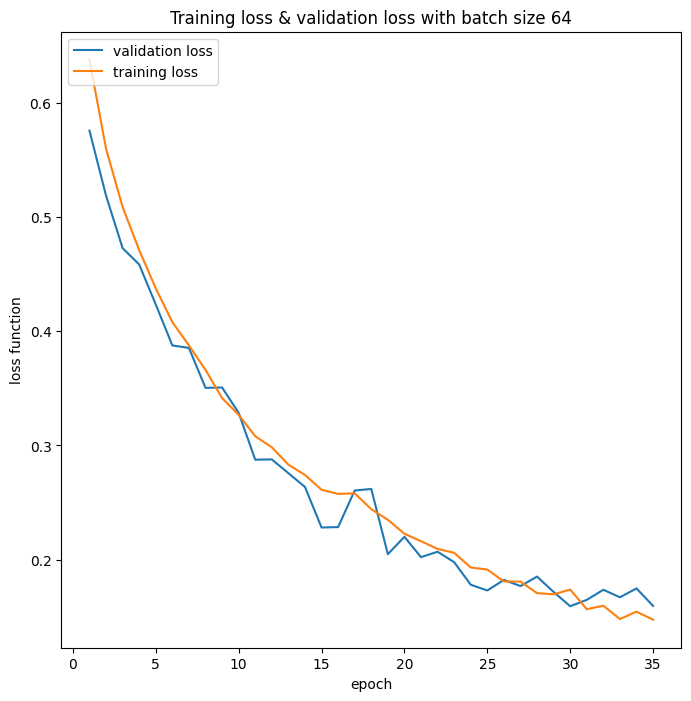

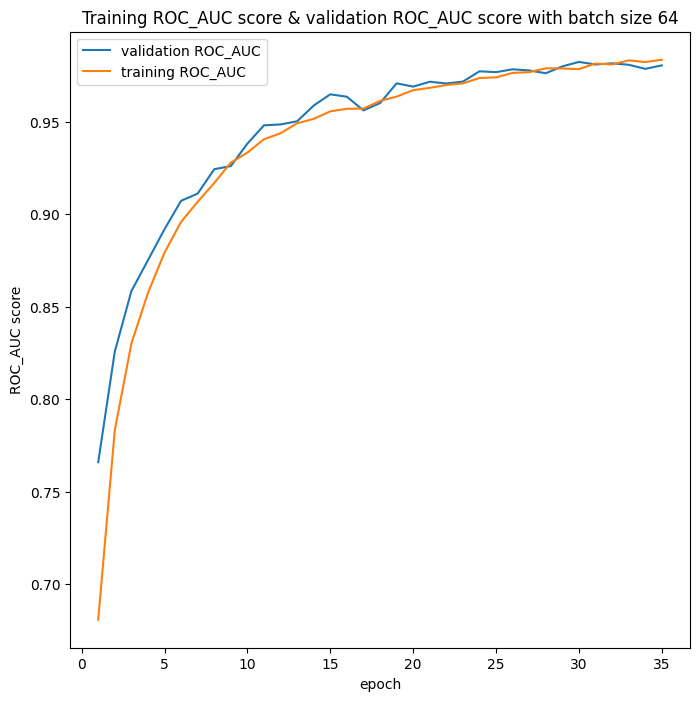

In [45]:
plot_performance(history9)

In [46]:
y_pred9 = predict_and_make_submission_file(model9,'sumbission_file_9.csv',batch_size = 64)
print(y_pred9)

193/193 [==============================] - 4s 16ms/step
(12326, 1)
12326
[5.6865644e-01 2.5687512e-04 9.7954732e-01 ... 5.6542713e-06 8.4383607e-01
 9.9071991e-01]


### observations:
* the model has an accuracy of 0.9835
* and a validation accuracy of 0.9804
* in kaggle public accuracy of 0.87933
* this model has the best accuracy on kaggle and colab

so i observed that this model is much better score than all models that used GGNN as message_calculation_class hyperparameters and with best validation accuracy, and I think it's because the relu resisted to vanishing gradient problem.

-------------------------------------------------------------------------------

### tenth trial

* In this trial, I increased the amount of trainable parameters and determine whether this model will overfit or whether its complexity will enable it to perform more accurately than in the trial before.

In [47]:
model10 = build_GCN(hidden_dim = 128 ,message_calculation_class = 'GGNN' ,dense_intermediate_layer_activation = 'relu', num_layers = 14)

model10.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           

In [48]:
model10, history10 = compile_and_train_model(model10, train_data, val_data, 'adam', 'BinaryCrossentropy', 'AUC', 64, 70)

Epoch 1/70
633/633 [==============================] - 96s 110ms/step - loss: 0.6558 - auc: 0.6509 - val_loss: 0.6316 - val_auc: 0.6994
Epoch 2/70
633/633 [==============================] - 68s 107ms/step - loss: 0.6329 - auc: 0.6895 - val_loss: 0.6472 - val_auc: 0.6957
Epoch 3/70
633/633 [==============================] - 67s 105ms/step - loss: 0.6075 - auc: 0.7271 - val_loss: 0.5668 - val_auc: 0.7843
Epoch 4/70
633/633 [==============================] - 69s 109ms/step - loss: 0.5582 - auc: 0.7862 - val_loss: 0.5356 - val_auc: 0.8097
Epoch 5/70
633/633 [==============================] - 70s 110ms/step - loss: 0.5251 - auc: 0.8172 - val_loss: 0.5193 - val_auc: 0.8264
Epoch 6/70
633/633 [==============================] - 69s 110ms/step - loss: 0.5027 - auc: 0.8348 - val_loss: 0.4779 - val_auc: 0.8546
Epoch 7/70
633/633 [==============================] - 70s 111ms/step - loss: 0.4604 - auc: 0.8649 - val_loss: 0.4311 - val_auc: 0.8878
Epoch 8/70
633/633 [==============================] - 6

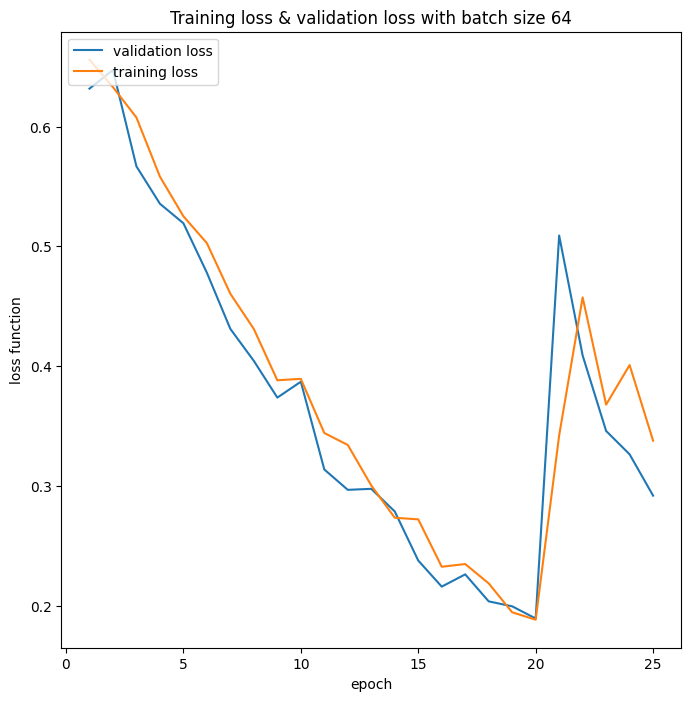

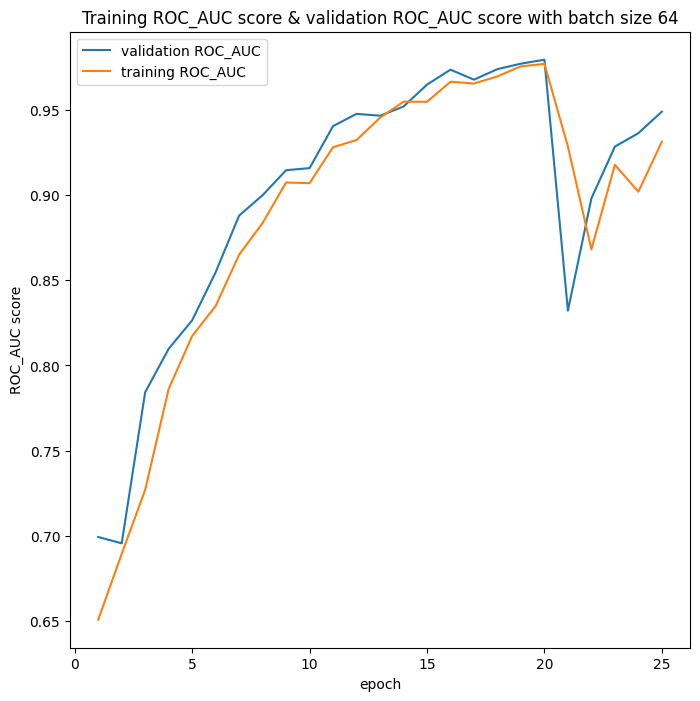

In [49]:
plot_performance(history10)

In [50]:
y_pred10 = predict_and_make_submission_file(model10,'sumbission_file_10.csv',batch_size = 64)
print(y_pred10)

193/193 [==============================] - 6s 28ms/step
(12326, 1)
12326
[1.6091819e-01 1.8161114e-02 9.0448499e-02 ... 2.4676777e-04 5.4967999e-01
 6.9391984e-01]


### observations:
* the model has an accuracy of 0.9311
* and a validation accuracy of 0.9488
* in kaggle public accuracy of 0.85172

so i observed that this model is the second optimal model in both kaggle and colab 

-------------------------------------------------------------------------------

### thanks 🤝